# Problem Sheet 3

- To be completed by **12noon** on Wed **23d Oct** and uploaded to [Problem Sheet 3 submission point](https://moodle.bath.ac.uk/mod/assign/view.php?id=1371307) on Moodle.

## Task (a): expected risk minimiser denoises data

Consider a function $f(t): [0,1] \rightarrow \mathbb{R}$, and time series data pairs $(t_i,y_i)$ generated as realisations of random variables $T \sim \mathcal{U}(0,1)$ which is uniformly distributed on $[0,1]$, and $Y = f(T) + \Xi$, where $\Xi$ is another random variable (simulating noise in the data) that is independent of $T$ and has $\mathbb{E}[\Xi] = 0$.
Consider any differentiable in $\boldsymbol\theta \in \mathbb{R}^n$ prediction rule $h_{\boldsymbol\theta}(t).$

- Prove that $\boldsymbol\theta^{best} = \arg\min_{\boldsymbol\theta \in \mathbb{R}^n} \mathbb{E}\left[(h_{\boldsymbol\theta}(T) - Y)^2\right]$ does not depend on $\Xi$.

_Hint: use the Problem Sheet 2 solutions as a warm-up._

#### Solution:

\begin{align*}
L(\boldsymbol\theta) & = \mathbb{E}[(h_{\boldsymbol\theta}(T) - Y)^2] = \mathbb{E}[(h_{\boldsymbol\theta}(T) - f(T) - \Xi)^2] \\
& = \mathbb{E}[h_{\boldsymbol\theta}(T)^2  - 2 h_{\boldsymbol\theta}(T) f(T) + f(T)^2 - 2h_{\boldsymbol\theta}(T)\Xi + 2f(T) \Xi + \Xi^2] \\
& = \mathbb{E}[h_{\boldsymbol\theta}(T)^2  - 2 h_{\boldsymbol\theta}(T) f(T) ] \\
& - 2\mathbb{E}[h_{\boldsymbol\theta}(T)] \cdot \underbrace{\mathbb{E}[\Xi]}_0 & \text{by independence of $T$ and $\Xi$}\\
& + \mathbb{E}[f(T)^2 + 2f(T) \Xi + \Xi^2] & \text{independent of $\boldsymbol\theta$}
\end{align*}
Hence
$$
\nabla L(\boldsymbol\theta) = \nabla \mathbb{E}[h_{\boldsymbol\theta}(T)^2  - 2 h_{\boldsymbol\theta}(T) f(T) ]
$$
which is independent of $\Xi$ and so is its root $\boldsymbol\theta^{best}$.

---

## Task 0 (Warm-up): simulating the "true" distribution
- Copied over the solution of Task 1 of Problem Sheet 2 (generation of synthetic data).

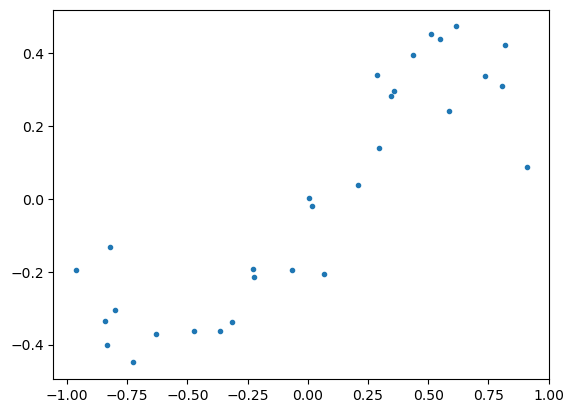

In [1]:
import numpy as np
from matplotlib import pyplot as plt    

def TrueSample():
    x = np.random.uniform(-1,1)
    y = x - x**3 + 0.1*np.random.randn()
    return x,y

Nsamples = 30
Y = np.zeros(Nsamples)
X = np.zeros(Nsamples)
for i in range(Y.size):
    X[i],Y[i] = TrueSample()

plt.plot(X,Y, '.')
plt.show()

## Task 1 (Warm-up): data splitting

- **Write a Python function** `split_data(X,Y,K,k)` that takes as input _numpy_ arrays X and Y as defined previously, a positive integer number of chunks K the data should be split into, and an index $0\le$ k $<$ K. The function should split X and Y into K subsets of equal size (you can assume that K divides the size of X and Y) and **return** 4 outputs: Xtrain, Ytrain, Xtest, Ytest, where Xtest and Ytest are the $k$-th subsets of X and Y, respectively, and Xtrain and Ytrain contain the rest of X and Y, respectively.

In [2]:
def split_data(X,Y,K,k):
    # Create an index array, split that, and then take X and Y at this index array
    N = X.shape[0]
    test_range = range(k*N//K, (k+1)*N//K)  # index array of the test range
    Xtest = X[test_range]
    Xtrain = np.delete(X, test_range, axis=0)  # delete Xtest from X
    Ytest = Y[test_range]
    Ytrain = np.delete(Y, test_range, axis=0)  # delete Ytest from Y
    return Xtrain, Ytrain, Xtest, Ytest

## Task 2: K-fold cross validation
- **Copy** over functions `features` and `optimise_loss` from Problem Sheet 1 or 2.
- **Write a Python function** `cv(X,Y,K,n)` that takes as input arrays X and Y, the number of folds K, and the polynomial degree n, and computes the cross validation loss as follows:
 - create an integer array `ind` containing a random shuffle of the $0,\ldots,N-1$ index sequence, where $N$ is the size of X and Y.
 - for each $k=0,\ldots,K-1$,
   - let $X_{train}, Y_{train}, X_{test},Y_{test}$ be training and test arrays produced from `split_data` with K folds applied to shuffled arrays `X[ind]`, `Y[ind]`, such that $X_{test},Y_{test}$ are the $k$-th chunks of `X[ind]`, `Y[ind]`, respectively.
   - compute $\boldsymbol\theta^{(k)} = \arg\min_{\boldsymbol\theta\in\mathbb{R}^{n+1}}L_{D_{train}}(\boldsymbol\theta)$ using `features` to compute the Vandermonde matrix, and `optimise_loss` to solve the equations, defined by $D_{train} = (X_{train}, Y_{train})$.
   - compute the $k$-th test loss $L_k:=L_{D_{test}^{(k)}}(\boldsymbol\theta^{(k)})$, where $D_{test}^{(k)}:=(X_{test},Y_{test})$.
 - Return the cross validation loss $L_{cv} = \frac{1}{K} \sum_{k=0}^{K-1}L_k$   

In [3]:
def features(x,n):
    powers = np.arange(n+1)               # [0,1,2,...,n]
    powers = np.reshape(powers, (1, -1))  # Make it explicitly a row vector
    x = np.reshape(x, (-1, 1))            # Make it explicitly a column vector
    return x**powers                      # Python automatically broadcasts the vectors to each others' shapes 
                                          # and takes the power between the resulting matrices elementwise

def optimise_loss(V,y):
    return np.linalg.solve(V.T @ V, V.T @ y)

In [4]:
def cv(X,Y,K,n):
    ind = np.arange(X.size)
    np.random.shuffle(ind)
    L = np.zeros(K)
    for k in range(K):
        Xtrain,Ytrain,Xtest,Ytest = split_data(X[ind],Y[ind],K,k)
        V = features(Xtrain, n)
        theta_k = optimise_loss(V, Ytrain)
        V = features(Xtest, n)
        L[k] = np.mean((V @ theta_k - Ytest)**2)
    return np.mean(L)

## Task 3: model selection
- **Vary** $n$ from 0 to 8 and **plot** the $5$-fold cross validation loss for datasets created in Task 0 as a function of $n$.
- **Find** which value of $n$ gives the smallest cross validation loss. Can we expect this value if we know how the datasets were produced in Task 0?

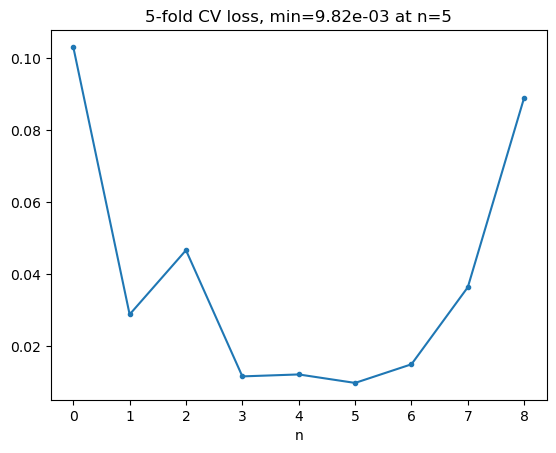

In [5]:
cvlosses = np.zeros(9)
for n in range(cvlosses.size):
    cvlosses[n] = cv(X, Y, 5, n)
plt.plot(np.arange(cvlosses.size), cvlosses, '.-')
plt.xlabel("n")
plt.title(f"5-fold CV loss, min={np.min(cvlosses):.2e} at n={np.argmin(cvlosses)}")
plt.show()

## Task 4: convergence of the cross validation loss
- **Vary** the number of samples in Task 0 in a range 30, 100, 300, 1000, 3000, and for each corresponding realisation of X and Y repeat the cross validation loss plotting in Task 2. What you observe as the number of samples gets larger?

#### Solution:
The CV loss should converge to values as above. Specifically, since the noiseless prediction rule is a cubic polynomial, the CV loss should reach the value of about 0.01 for any $n\ge 3$. The value of 0.01 is the variance of the noise $\frac{1}{10} \Xi$, which is also the minimal expected loss $L_{bias}$ for $n \ge 3$.